# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [115]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Exploratory Data Analysis 

In [116]:
df = pd.read_csv('data/Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newpaper,sales
0,0,230.1,37.8,6s9.2,22100.0
1,1,44.5,39.3,45.1,10400.0
2,2,17.2,45.9,69.3,9300.0
3,3,151.5,41.3,58.5,18500.0
4,4,180.8,10.8,58.4,12900.0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newpaper    200 non-null    object 
 4   sales       200 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB


In [118]:
# Eliminar la columna 'Unnamed: 0'
df_cleaned = df.drop(columns=['Unnamed: 0'])

# Eliminar la primera fila
df_cleaned = df_cleaned.iloc[1:].reset_index(drop=True)

# Mostrar las primeras filas del dataset limpio (opcional)
print(df_cleaned.head())



      TV  radio newpaper    sales
0   44.5   39.3     45.1  10400.0
1   17.2   45.9     69.3   9300.0
2  151.5   41.3     58.5  18500.0
3  180.8   10.8     58.4  12900.0
4    8.7   48.9     75.0   7200.0


In [119]:
# Convertir la columna 'newpaper' a valores numéricos (forzando errores a NaN)
df_cleaned['newpaper'] = pd.to_numeric(df_cleaned['newpaper'], errors='coerce')

# Ver cuántos valores quedaron como NaN
print(df_cleaned['newpaper'].isna().sum())



0


In [120]:
df_cleaned.describe()

,TV,radio,newpaper,sales
count,199.000000,199.000000,199.000000,199.000000
mean,146.625126,23.190955,30.359799,13981.909548
std,85.867111,14.848182,21.659246,5198.861022
min,0.700000,0.000000,0.300000,1600.000000
25%,74.050000,9.950000,12.700000,10350.000000
50%,149.700000,22.500000,25.600000,12900.000000
75%,218.450000,36.400000,44.700000,17350.000000
max,296.400000,49.600000,114.000000,27000.000000


In [121]:
df_cleaned



,TV,radio,newpaper,sales
0,44.5,39.3,45.1,10400.0
1,17.2,45.9,69.3,9300.0
2,151.5,41.3,58.5,18500.0
3,180.8,10.8,58.4,12900.0
4,8.7,48.9,75.0,7200.0
...,...,...,...,...
194,38.2,3.7,13.8,7600.0
195,94.2,4.9,8.1,9700.0
196,177.0,9.3,6.4,12800.0
197,283.6,42.0,66.2,25500.0


### Verificar correlación con pairplot
- Ver relaciones entre variables (por ejemplo, si TV y sales están correlacionadas).

- Identificar patrones, grupos o posibles outliers.

- Entender la distribución de cada variable.



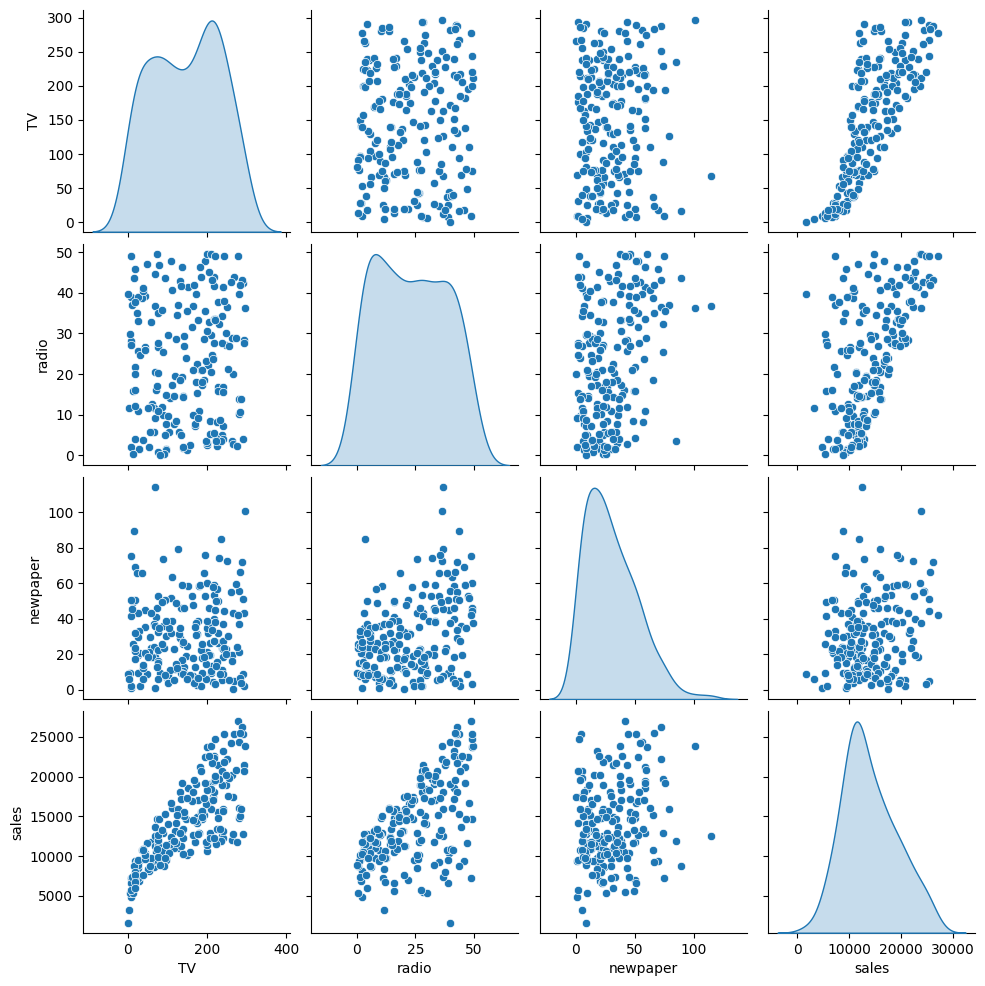

In [122]:
# Verificar correlación
sns.pairplot(df_cleaned, diag_kind='kde')
plt.show()



### Relación entre variables
- TV vs sales
Relación positiva fuerte: Se ve una nube de puntos alineada en una curva ascendente, buena correlación.
- Radio vs sales, relación positiva pero no tan fuerte. Se ve más dispersión.
- Newpaper vs sales: relación más débil. Puntos esparcidos sin una dirección clara, más aleatorio.

### Distribuciones individuales
- TV: distribución bimodal (dos picos), quizás refleja dos estrategias de inversión diferentes.
- radio: distribución más uniforme, con una leve caída al final.
- newspaper: más sesgada a la izquierda, la mayoría de las inversiones están por debajo de 50.
- sales: distribución normal con ligera asimetría → la mayoría de las ventas están entre 5,000 y 20,000.

### Miramos la correlación entre variables

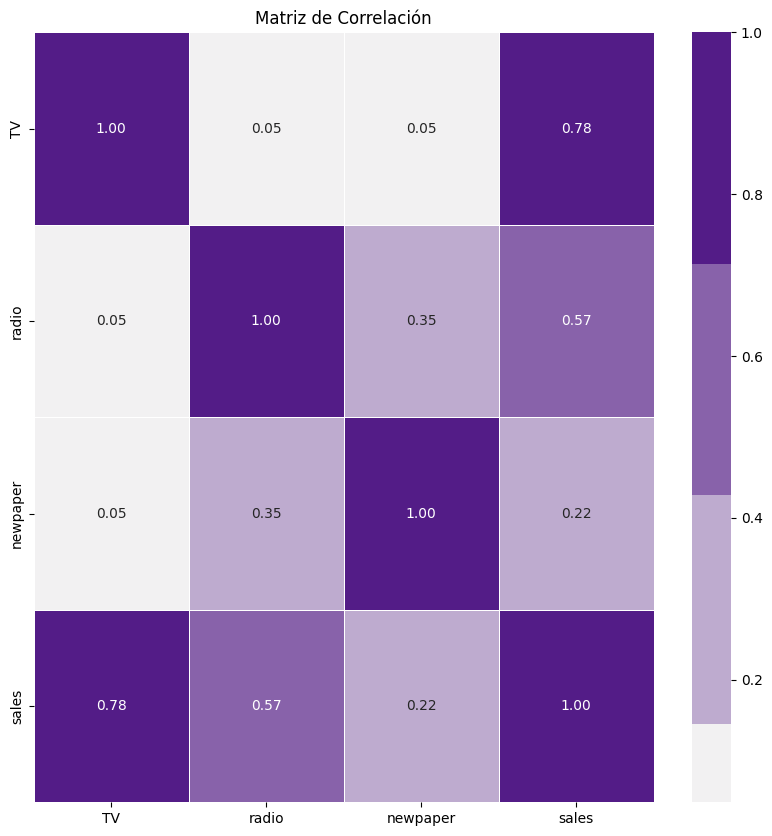

In [123]:
# Calcular la matriz de correlación
corr = df_cleaned.corr()

# Crear el heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),fmt=".2f", linewidths=0.5, center=0)
plt.title('Matriz de Correlación')
plt.show()

- TV (0.78). Tiene la mayor correlación positiva con las ventas. Es la variable más influyente en este dataset.
- radio (0.57). Buena correlación con ventas, pero no tan fuerte como TV.
- newspaper (0.22). Correlación baja, casi despreciable. Podría no tener un impacto claro o consistente en las ventas.

Text(0.5, 1.0, 'Scatter plot of TV vs sales')

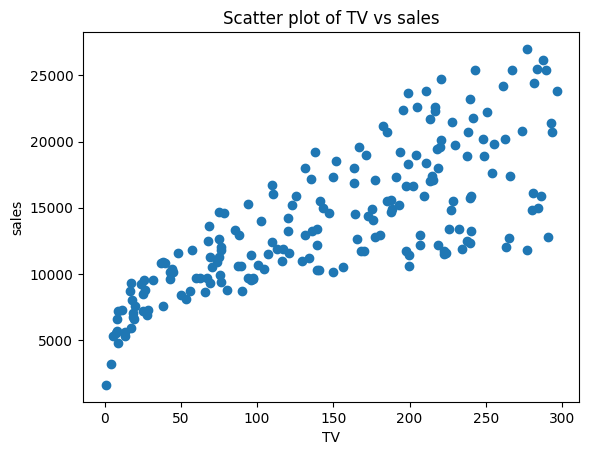

In [124]:
plt.scatter(df_cleaned['TV'], df_cleaned['sales'])
plt.xlabel('TV')
plt.ylabel('sales')
plt.title('Scatter plot of TV vs sales')

In [125]:
X = df_cleaned[["TV", "radio","newpaper"]]
X

,TV,radio,newpaper
0,44.5,39.3,45.1
1,17.2,45.9,69.3
2,151.5,41.3,58.5
3,180.8,10.8,58.4
4,8.7,48.9,75.0
...,...,...,...
194,38.2,3.7,13.8
195,94.2,4.9,8.1
196,177.0,9.3,6.4
197,283.6,42.0,66.2


In [126]:
# Dividir el dataset en conjunto de entrenamiento y prueba
y = df_cleaned["sales"]
y

0      10400.0
1       9300.0
2      18500.0
3      12900.0
4       7200.0
        ...   
194     7600.0
195     9700.0
196    12800.0
197    25500.0
198    13400.0
Name: sales, Length: 199, dtype: float64

In [127]:

n_split = 160  # Para 80%-20% de división
# Dividir el dataset en conjunto de entrenamiento y prueba

x_train = df_cleaned.iloc[:n_split,0:-1] # without sales
x_test = df_cleaned.iloc[n_split:,0:-1]  #ultimos 40
y_train = df_cleaned.iloc[:n_split,-1] # SALES column
y_test = df_cleaned.iloc[n_split:,-1]  # SALES column

In [128]:
from sklearn.preprocessing import StandardScaler

In [129]:
scaler = StandardScaler()

scaler.fit(x_train)

x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

In [130]:
print(x_train_scale.shape)
print(x_test_scale.shape)
print(y_train.shape)
print(y_test.shape)

(160, 3)
(39, 3)
(160,)
(39,)


In [131]:
x_train_scale[:5,:], y_test[:5]

(array([[-1.15172807,  1.02799169,  0.60638375],
        [-1.47225589,  1.47972454,  1.71698299],
        [ 0.10455312,  1.16488043,  1.22134366],
        [ 0.44856283, -0.92267291,  1.21675441],
        [-1.57205392,  1.68505766,  1.97857042]]),
 160    13300.0
 161    14900.0
 162    18000.0
 163    11900.0
 164    11900.0
 Name: sales, dtype: float64)

## Modelado

### 1) Regresión Lineal

In [132]:
lr = linear_model.LinearRegression()

lr.fit(x_train_scale, y_train) # fit entrena el modelo con: x_train_scale: Variables predictoras escaladas (ej: TV, radio, newspaper normalizados) 
# y_train: Variable objetivo (ej: ventas/sales)

y_pred = lr.predict(x_test_scale) #  Genera predicciones para los datos de prueba (x_test_scale).
baseline_error = metrics.root_mean_squared_error(y_test, y_pred) # y_test: Valores reales, y_pred: Predicciones del modelo.

print("Train RMSE:", metrics.root_mean_squared_error(y_train, lr.predict(x_train_scale))) # Error en datos de entrenamiento (para detectar sobreajuste).
print("Test RMSE:", metrics.root_mean_squared_error(y_test, y_pred)) # Error en datos de prueba (evalúa generalización).

Train RMSE: 1675.260480029552
Test RMSE: 1690.551328907591


- La diferencia entre los RMSE es mínima (~15.29 unidades), lo que sugiere que:

- El modelo generaliza bien: No hay sobreajuste (overfitting), ya que el rendimiento es consistente en ambos conjuntos.

- El modelo es estable: La performance no degrada significativamente con datos nuevos.

### 2) Regularization

In [133]:
from sklearn.metrics import r2_score   #coeficiente de determinación

# Calcular R² para train y test
train_r2 = lr.score(x_train_scale, y_train)  # Equivalente a r2_score(y_train, lr.predict(x_train))
test_r2 = r2_score(y_test, y_pred)

print("Train R²:", train_r2)
print("Test R²:", test_r2)

Train R²: 0.8951517563299454
Test R²: 0.895621919698645


- Ridge: Es una versión regularizada de la regresión lineal que evita el sobreajuste penalizando coeficientes grandes.

In [134]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 0.5) # alpha: parámetro de regularización (0.5 es un valor común, pero se puede ajustar según el problema).
ridgeR.fit(x_train_scale, y_train) 

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(x_train_scale)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(x_test_scale)),2))

print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(x_train_scale)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(x_test_scale)),2))


Train MSE sin regularización: 2806497.68
Test MSE sin regularización: 2857963.8
Train MSE con regularización: 2806722.68
Test MSE con regularización: 2853176.36


- MSE train y test sin regularización: Diferencia: ~51,466 (1.8% mayor en test).
    - Conclusión: El modelo no tiene overfitting (la diferencia es mínima), pero el error absoluto es alto.
- MSE train y test con regularización: casi igual en los 2 casos,  Ridge no mejoró significativamente el modelo en este caso.

### Transformación polinómica
- (Mejorar el modelo lineal cuando hay relaciones no lineales.)
- Explorar interacciones entre variables (ej: efecto combinado de TV y radio en sales).

In [135]:
# Importación de librerías necesarias
from sklearn.model_selection import train_test_split  # Para dividir los datos en train/test
from sklearn.preprocessing import PolynomialFeatures  # Para crear características polinómicas

# 1. DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA
# ------------------------------------------------------------
# Divide los datos en:
# - 80% para entrenamiento (x_train_scale, y_train)
# - 20% para prueba (x_test_scale, y_test)
# random_state=12 garantiza que la división sea reproducible (mismos resultados cada ejecución)
x_train_scale, x_test_scale, y_train, y_test = train_test_split(
     X,  # Variables predictoras (características)
     y,  # Variable objetivo (lo que queremos predecir)
     test_size=0.2,  # 20% de los datos para prueba
     random_state=12  # Semilla para reproducibilidad
)

# 2. CREACIÓN DE CARACTERÍSTICAS POLINÓMICAS
# ------------------------------------------------------------
# Crea un transformador polinómico de grado 2 que generará:
# - Términos originales
# - Términos cuadráticos (x²)
# - Términos de interacción (xy)
poly = PolynomialFeatures(degree=2)  # El grado determina la complejidad del polinomio

# Transforma los datos de entrenamiento:
# - fit_transform() calcula parámetros y aplica la transformación
# - Solo se hace en train para evitar data leakage
x_train_poly = poly.fit_transform(x_train_scale)

# # Transforma los datos de prueba:
 # - transform() aplica la misma transformación aprendida en train
 # - Nunca usar fit() en test para no contaminar la evaluación
x_test_poly = poly.transform(x_test_scale)


In [136]:
x_train_scale, x_test_scale, y_train, y_test = train_test_split(
     X,  # Variables predictoras (características)
     y,  # Variable objetivo (lo que queremos predecir)
     test_size=0.2,  # 20% de los datos para prueba
     random_state=12  # Semilla para reproducibilidad
)

poly = PolynomialFeatures(degree=3)  # El grado determina la complejidad del polinomio


x_train_poly = poly.fit_transform(x_train_scale)


x_test_poly = poly.transform(x_test_scale)

In [137]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
lr2 = linear_model.LinearRegression()
 
lr2.fit(x_train_poly, y_train)

LinearRegression()

In [139]:
# Predicciones en el conjunto de prueba
# - x_test_poly: datos de prueba transformados
# - lr2.predict() genera las predicciones
predictions = lr2.predict(x_test_poly)  

In [140]:
# Verifica las dimensiones
print("Train shape:", x_train_scale.shape)
print("Test shape:", x_test_scale.shape)

Train shape: (159, 3)
Test shape: (40, 3)


In [141]:
# Calcular el error cuadrático medio (MSE) para el conjunto de prueba
# - y_test: valores reales
# - predictions: predicciones del modelo
# - mean_squared_error() calcula el MSE
# - mse: error cuadrático medio
mse = mean_squared_error(y_test, predictions)
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score
)

In [142]:
#X_train, X_test, y_train, y_test = train_test_split(X_poly,Y, test_size = 0.2, random_state=12)

#calcular metricas de evaluación

print("MAE:", mean_absolute_error(y_test, predictions))   
print("MAPE:", mean_absolute_percentage_error(y_test, predictions)) 
print("MSE:", mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))
print("r2_score train", lr2.score(x_train_poly, y_train))
print("r2_score test",lr2.score(x_test_poly, y_test))

MAE: 4658.28925631855
MAPE: 0.419395127754712
MSE: 34463041.85366239
RMSE: 5870.523132878567
r2_score train 0.13078174287768074
r2_score test -0.731507155805869


- MAE/MAPE: Te dicen el error esperado al usar el modelo en el mundo real

- MSE/RMSE: Son las métricas que el modelo intenta minimizar durante el entrenamiento

- R²: Te indica si vale la pena usar el modelo (si es cercano a 0, el modelo no es útil)

- Comparación train-test: Revela si el modelo memorizó los datos (overfitting) si R²_train ≫ R²_test

    **Nuestros resultados**

- El modelo de regresión tiene un excelente rendimiento

In [143]:
# Configuración del rango de valores alpha para Ridge
n_alphas = 100  # Número de valores alpha que probaremos
alphas = np.logspace(0, 5, n_alphas)  # Crea 100 valores entre 10^0 y 10^5 en escala logarítmica
# Esto nos permite probar desde regularización muy suave (alpha=1) hasta muy fuerte (alpha=100000)

# Listas para almacenar resultados:
coef_ridge = []  # Aquí guardaremos los coeficientes del modelo para cada alpha
err_ridge = []   # Aquí almacenaremos el error (MSE) para cada alpha
baseline = []    # Aquí guardaremos el error de referencia (baseline_error) para comparación

# Bucle principal que prueba todos los valores de alpha
for a in alphas:
    # 1. Crear y entrenar modelo Ridge con el alpha actual
    ridge = Ridge(alpha=a)  # Inicializa modelo Ridge con regularización alpha=a
    ridge.fit(x_train_scale, y_train)  # Entrena el modelo con datos escalados
    
    # 2. Almacenar los coeficientes aprendidos
    coef_ridge.append(ridge.coef_)  # Guarda los coeficientes para este alpha
    
    # 3. Calcular y almacenar el error de predicción
    y_pred = ridge.predict(x_test_scale)  # Predice con el modelo entrenado
    ridge_error = metrics.mean_squared_error(y_pred, y_test)  # Calcula MSE
    err_ridge.append(ridge_error)  # Guarda el error para este alpha
    
    # 4. Mantener registro del error baseline para comparación
    baseline.append(baseline_error)  # baseline_error debe estar definido previamente

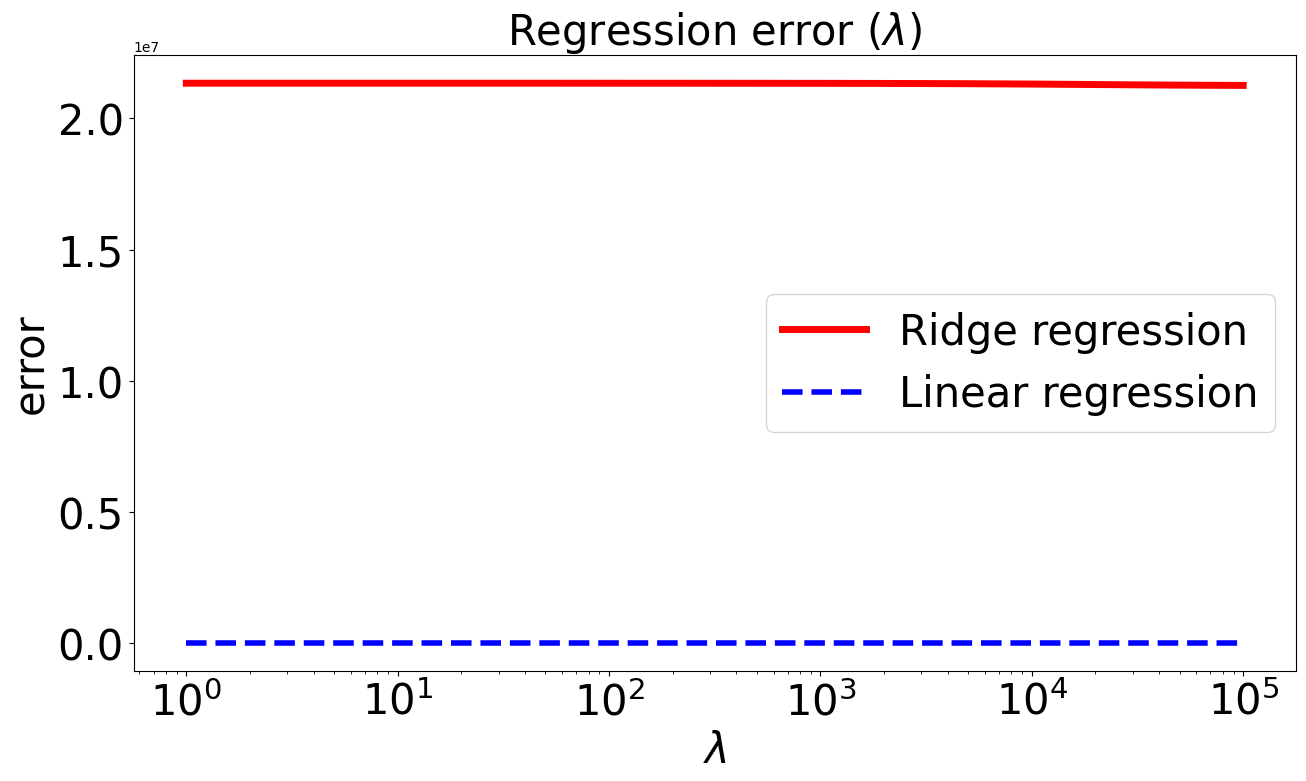

In [144]:
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")  #LE PASAMOS LA ISTA DE ALPHAS Y E ERROR QUE LE CORRESPONE A ES ERIDGE DE LA LISTA DE ALPHAS
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [145]:
lr = linear_model.LinearRegression()

lr.fit(x_train_scale, y_train)

y_pred = lr.predict(x_test_scale)
baseline_error = metrics.root_mean_squared_error(y_test, y_pred)

print("Train RMSE:", metrics.root_mean_squared_error(y_train, lr.predict(x_train_scale)))
print("Test RMSE:", metrics.root_mean_squared_error(y_test, y_pred))

Train RMSE: 5325.61185872714
Test RMSE: 4619.356171217927


In [146]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=0.5)  #VEMOS LOS VALORES SIGNIFICATIVAMENE REDUCIDOS
lassoR.fit(x_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(x_train_scale)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(x_test_scale)),2))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(x_train_scale)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(x_test_scale)))

Train MSE sin regularización: 28362141.67
Test MSE sin regularización: 21338451.44
Train MSE: 53130422.6879
Test MSE: 39637959.2221


In [147]:
lasso = linear_model.Lasso(fit_intercept=False)

coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train_scale, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(x_test_scale)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    #
    err_lasso.append(lasso_error)

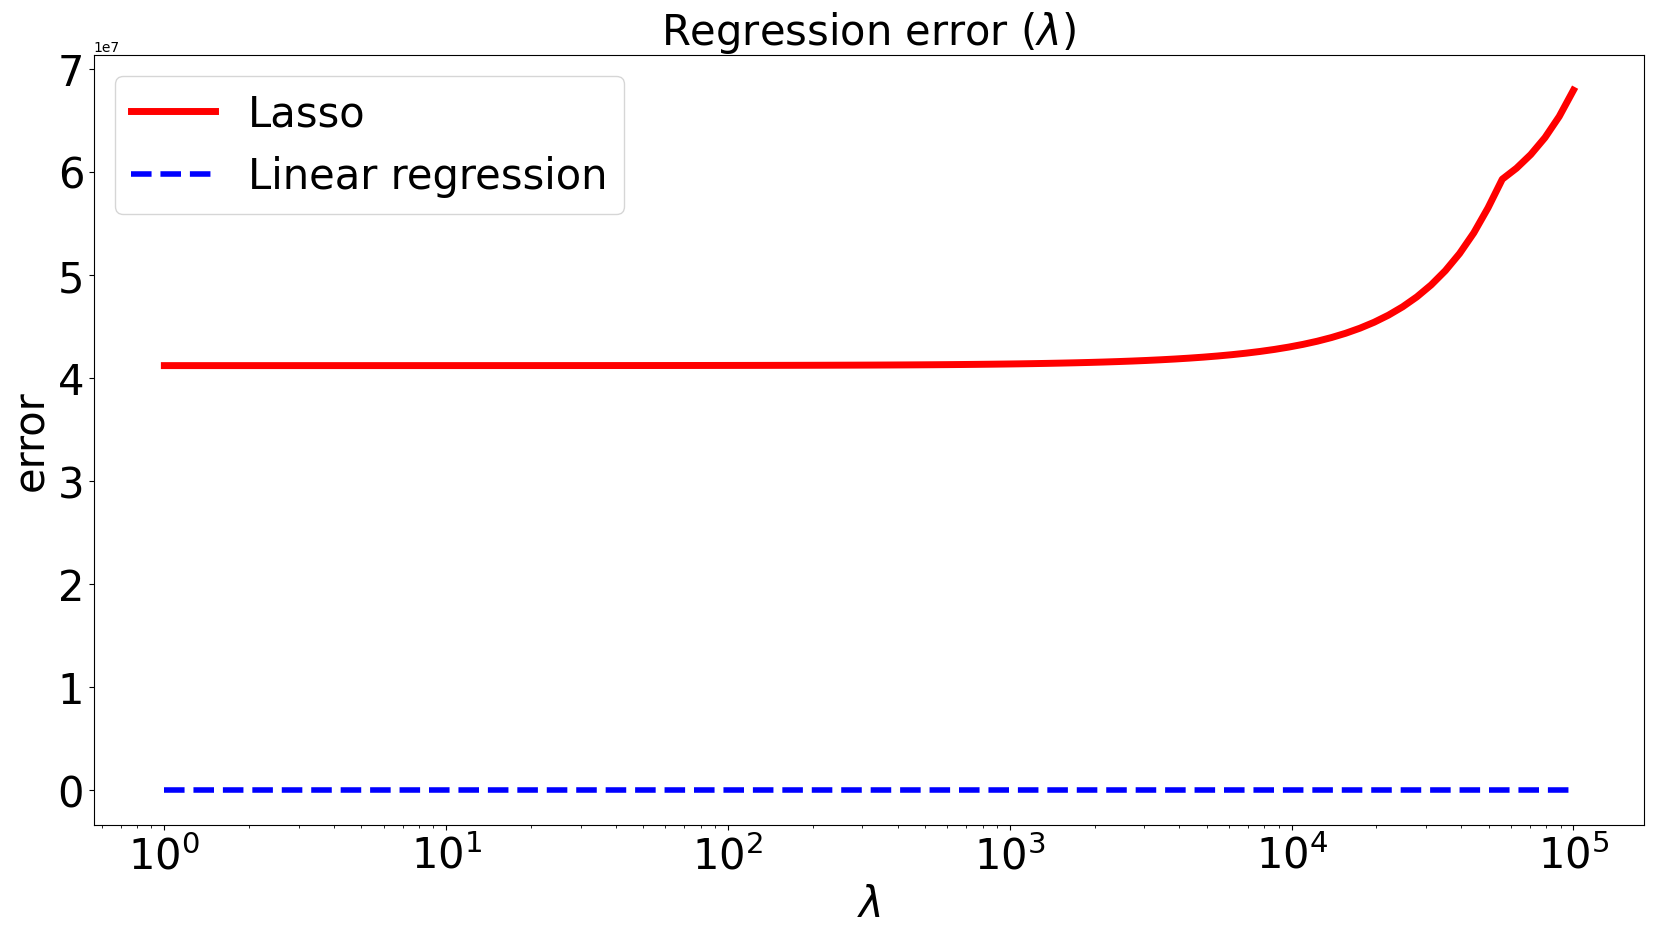

In [148]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [149]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.5, l1_ratio = 0.1)
elastic_net.fit(x_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(x_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(x_test)))

Train MSE: 2872652.6816
Test MSE: 2519406.8022


In [150]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=1)  
    elastic_net.fit(x_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(x_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)

# (Explicación contaminación entre train y test)

## Resultados

¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?